In [1]:
# Imports for the notebook
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex

In [2]:
from wand.image import Image as WImage
# Insert figures: 
img1 = WImage(filename='./figures_ch8/pid_complex_poles.pdf')
img2 = WImage(filename='./figures_ch8/pid_damping_ratio.pdf')
img3 = WImage(filename='./figures_ch8/pid_loop-SLC-OL.pdf')
img4 = WImage(filename='./figures_ch8/pid_loop-SLC-12.pdf')
img5 = WImage(filename='./figures_ch8/pid_loop-SLC-2.pdf')
img6 = WImage(filename='./figures_ch8/hw_pendulum_PD_inner.pdf')
img7 = WImage(filename='./figures_ch8/hw_pendulum_PD_outer.pdf')
img8 = WImage(filename='./figures_ch8/hw_satellite_PD_inner.pdf')
img9 = WImage(filename='./figures_ch8/hw_satellite_PD_outer.pdf')

# Part 3: PID Control Design
## Chapter 8: Design Strategies for Second-order Systems

### Lecture Notes

This notebook covers the material in Chapter 8 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical. 

## A: First Order Response

Consider a first order system given by
$$Y(s) = \frac{p}{s+p} U(s),$$
where $p>0$.  The pole location of the first order system is then at $-p$.  

If $U(s)=\frac{A}{s}$ is a step of magnitude $A$, then the response of our first-order system to the step is 
$$Y(s) = \frac{Ap}{s(s+p)}.$$

We can simulate what the response of the system is to the step of magnitude $A$ by using the `step` command in the control library.   

### Step Size Impacts
The response is shown in the figure below, which shows the response to steps of size $A=1$, $A=2$, and $A=3$, respectively.

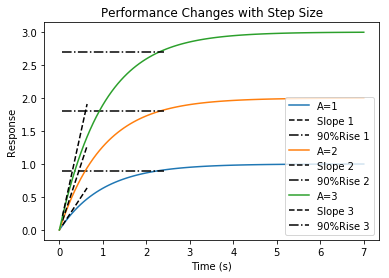

In [3]:
## Plot our basic TF with different magnitudes of A

# Feel free to adjust the pole position p or the elements of A and see what changes:
p = 1
A = [1,2,3]


# TODO: wrap it all up in a function in a separate file
fig, ax = plt.subplots()
for a in A:
    num = a*p
    den = [1.,p]
    H0 = c.tf(num,den)
    # Step responses
    y0, t = step(H0)
    # Initial slopes:
    ts = t[1:10]
    s0 = (a/p)*ts 
    # 90% rise times
    t9 = t[1:35]
    r0 = 0.9*a*np.ones(t9.size)
    ax.plot(t,y0,label='A='+str(a))
    ax.plot(ts,s0,'k--',label='Slope '+str(a))
    ax.plot(t9,r0,'k-.',label='90%Rise '+str(a))
plt.title('Performance Changes with Step Size')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

If we define the rise time $t_r$ of the system to be the **time after the step when the response reaches 90\%** of its final value, then note from the figure above that the *rise time is independent of the step size $A$.*  

By differentiating the time response equation above,at time $t=0$, it is straightforward to show that the slope of the response at $t=0$ is equal to $Ap$.  This is also shown graphically in the figure above.

### Pole Location Impacts
Next we discuss how changes in the pole location $p$ adjust the performance of the system.  As we vary p, see what takes place: 

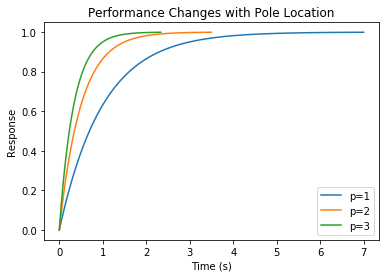

In [4]:
# Feel free to adjust the elements of p2 or the magnitude of of A2 to see what happens
p2 = [1,2,3]
A2 = 1

# TODO: wrap up into function and place in other file. 
# TODO: wrap it all up in a function in a separate file
fig, ax = plt.subplots()
for p in p2:
    num = p*A2
    den = [1.,p]
    H0 = c.tf(num,den)
    # Step responses
    y0, t = step(H0)
    ax.plot(t,y0,label='p='+str(p))
plt.title('Performance Changes with Pole Location')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

Note that as the pole location moves further into the left half of the complex plane, the rise time decreases.

## DC Gain
An important concept for the steady state response of a system (any order, not just 1st order) is the **DC-gain**, which is defined as follows.

**Definition:**
The DC-gain of a transfer function $H(s)$ is 
$$\left. H(s)\right|_{\text{DC-gain}} = \lim_{s\to 0} H(s).$$

An important fact is that if the poles of $H(s)$ are in the open left half plane, then the response of $H(s)$ to a step of size $A$ approaches $A \left.H(s)\right|_{\text{DC-gain}}$ as $t\to\infty$.  This is true for first order systems, as well general $H(s)$. 

The DC gain, for our first example above, is then 
$$\left. H(s)\right|_{\text{DC-gain}} = \lim_{s\to 0}  \frac{p}{s+p} =  1.$$

## B: Second Order Response
Suppose that the closed-loop system has a second order transfer function with two real poles and no zeros:
$$Y(s) = \frac{K}{(s+p_1)(s+p_2)}Y_r(s).$$

To find the output of the system when the input is a step of magnitude $A$, we find the inverse Laplace transform of
$$Y(s) = \frac{K}{(s+p_1)(s+p_2)}\frac{A}{s}.$$ (See text for more steps)

Likewise here, we can simulate the response to a step of magnitude $A$ for a second order system with the `step` command in the control library.  

Note that DC Gain for this system is: 
$$\lim_{s\to 0} \frac{K}{(s+p_1)(s+p_2)} $$
which results in: $\frac{K}{p_1 p_2}$

### Generic Second Order System
Now suppose that the closed loop system has two complex poles and no zeros.  We will write a generic second order system with poles in the left half plane using the notation
$$H(s) = \frac{K\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2},$$

were $K$ is the DC-gain of the system (typically $K=1$), $\omega_n>0$ is called the **natural frequency**, and $\zeta>0$ is called the **damping ratio**. 

The poles are given by the roots of the characteristic polynomial
$$\Delta(s) = s^2 + 2\zeta\omega_n s + \omega_n^2,$$
in other words, the poles are
\begin{align*}
p_{1,2} &= -\zeta\omega_n \pm \sqrt{(\zeta\omega_n)^2-\omega_n^2} \\
  &= -\zeta\omega_n \pm \omega_n\sqrt{\zeta^2-1}.
\end{align*}

Below we investigate how the step response of the second order system varies with changes in $\zeta$ and $\omega_n$.  

Text(0.5,1,'Performance Changes with $w_n$')

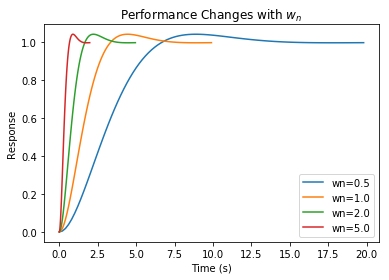

In [5]:
# Show how the step repsonse of the system changes with w_n and zeta

# Feel free to change zeta and the elements of wn and investigate the changes in plot below
zeta = 0.707
wn  = [.5,1.,2.,5.]

#Hold zeta constant, vary wn
fig, ax = plt.subplots()
for w in wn:
    G = tf(w*w,[1,2*zeta*w,w*w])
    g,t = step(G)
    ax.plot(t,g,label='wn='+str(w))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Performance Changes with $w_n$')

Text(0.5,1,'Performance Changes with $\\zeta$')

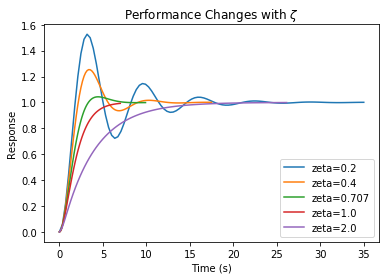

In [6]:
# Now hold wn constant, and vary zeta
# Feel free to vary the parameters and see how things change: 
wn = 1
zeta=[.2,.4,.707,1.,2.]

fig, ax = plt.subplots()
for z in zeta:
    G = tf(wn*wn,[1,2*z*wn,wn*wn])
    g,t = step(G)
    ax.plot(t,g,label='zeta='+str(z))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Performance Changes with $\zeta$')

Note from the figures above that as the natural frequency increases, the rise time decreases. We should note that a similar phenomena to the first order response also occurs, where the rise time is independent of the size of the step.  

Note from the above figures that the damping ratio effects the amount of ringing in the system.  For a small damping ratio, e.g., $\zeta=0.2$ there is a large overshoot and significant ringing in the system.  At the other extreme, when $\zeta$ is larger than one, the poles are real and the response is highly damped.  The sweet spot is when $\zeta=0.707$ where the rise time is small, but the overshoot is minimal. 

### Complex Plane
In the complex plane, the pole locations are shown in the next figure, where $\omega_n$ is the distance from origin to the poles.  When $\zeta=\frac{1}{\sqrt{2}}$ the angle $\theta$ equals $45$ degrees.  

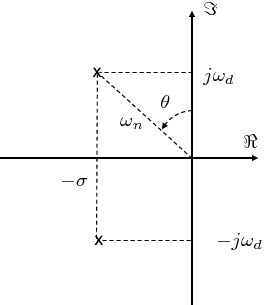

In [7]:
img1

In rectangular coordinates, the poles are given by
\begin{equation}\label{eq:complex_rectangular}
p_{1,2} = -\sigma \pm j\omega_d,
\end{equation}
as shown above. 

We also have
\begin{align*}
\sigma &= \zeta \omega_n \\
\omega_d &= \omega_n\sqrt{1-\zeta^2}.
\end{align*}

From the above figure, it is also clear that
$$\sin\theta = \frac{\sigma}{\omega_n} = \zeta.$$
Therefore
$$\theta = \sin^{-1} \zeta.$$

### System Damping
Since the pole locations are at $-\zeta \omega_n \pm \omega_n \sqrt{\zeta^2-1}$ there are three possible configurations:
* The poles are both real if $\zeta> 1$. The system is referred to as **over damped**. 
* When $\zeta=1$ the poles are real and both located at $-\omega_n$.  The system is referred to as **critically damped** 
* When $0<\zeta<1$ the are imaginary and occur in complex conjugate pairs.  The system is referred to as **under damped**   

This concept is demonstrated visually in the figure below. 

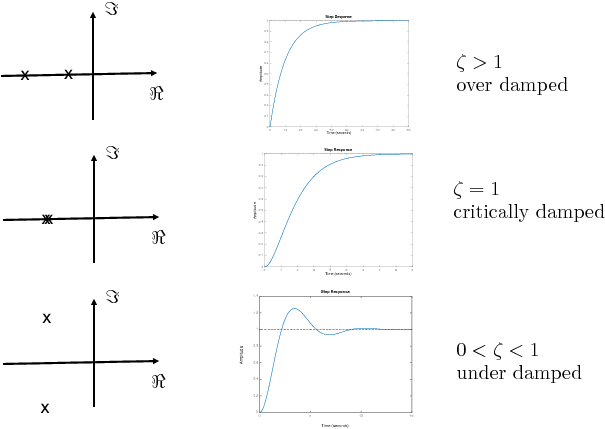

In [8]:
img2

TODO: Remake this plot into an interactive plot. 

### Rise Time for Second Order Systems

The rise time is defined to be time that it takes the output to transition from 10\% to 90\% of its final value $A$. A suitable approximation is that the rise time is one half of the peak time, which is the time when $y(t)$ reaches its first peak.  

To find the peak time $t_p$, differentiate $y(t)$ and then solve for the first instant of time when the derivative is zero.  The result is
$$
t_p = \frac{\pi}{\omega_d} = \frac{\pi}{\omega_n\sqrt{1-\zeta^2}}.
$$
Therefore, the rise time is approximately
$$
t_r \approx \frac{1}{2}t_p = \frac{1}{2}\frac{\pi}{\omega_n\sqrt{1-\zeta^2}}.
$$
When $\zeta=0.707$ we get
\begin{equation}\label{eq:rise_time}
t_r \approx \frac{2.2}{\omega_n}.
\end{equation}

Specifications for second order systems are usually given either in terms of the rise time $t_r$ and the damping ratio $\zeta$, or in terms of the natural frequency $\omega_n$ and the damping ratio $\zeta$.

## C: Impact of Zero on Step Response

Review the deriation of the effects of a zero on a notional second order system in the text.  Here we demonstrate an interactive plot for seeing the effect of the zero.  Try placing the zero closer to the origin than the poles, at or near one of the poles, and to the left of the poles and see how the response changes.  For a denominator of type `[1.,5.,6.]` the poles are at `-2.0` and `-3.0`.  

No Zero:

      6
-------------
s^2 + 5 s + 6

Including Zero:

  12 s + 6
-------------
s^2 + 5 s + 6



Text(0.5,1,'Performance Changes with a Zero at -0.5')

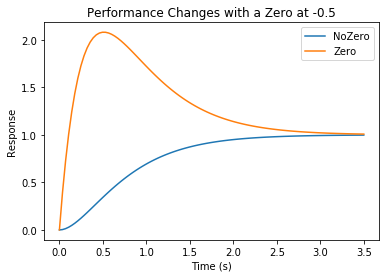

In [9]:
# Select the zero location and observe the impact on the overall system performance
z = .5; # Want z to be in the left-half plane (make it negative or zero)

# You can also play with the locations of the poles, the numerator will be computed to maintain a DC gain of 1 
# (with exception of having a pole at the origin):
den = [1.,5.,6.]



A = den[2]
num = A
if z==0.:
    numz = [A,0.]
    #NOTE: `elif [cond]:` is python for `else if ( [cond] )` in other languages
else:
    numz = [A/z*1.,A]
    
H0 = c.tf(num,den)
Hz = c.tf(numz,den)
# Print our transfer functions:
print('No Zero:',H0,'Including Zero:',Hz,sep='\n')

# Look at the step response:
fig, ax = plt.subplots()
h0,t = step(H0)
hz,tz = step(Hz)
ax.plot(t,h0,label='NoZero')
ax.plot(tz,hz,label='Zero')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Performance Changes with a Zero at -'+str(z))


## D: Successive Loop Closure
The natural frequency $\omega_n$ and the damping ratio $\zeta$ are only defined for second order systems, and therefore, the PD design technique based on $\omega_n$ and $\zeta$ are only valid for second order systems.  However, these concepts can be extended to higher order systems through a technique called successive loop closure\index{successive loop closure}, or inner-loop, outer-loop design.

So for a system that we can configure to be like the following (may have to make simplifying assumptions to make this possible), 

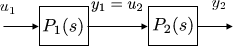

In [10]:
img3

we can design a successive system of controllers using 2nd order principles, like so: 

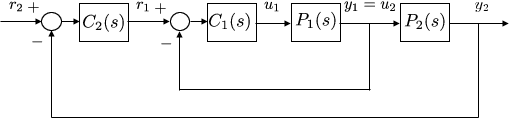

In [11]:
img4

The open-loop dynamics are given by
the product of two transfer functions in series:  $P(s)=P_1(s)P_2(s)$.
We assume that each of the transfer functions has an output ($y_1$, $y_2$) that can
be measured and used for feedback.  Typically, each of the transfer functions,
$P_1(s)$, and $P_2(s)$, is of relatively low order - usually first or
second order.  In this case, we are interested in controlling
the output $y_2$.

A necessary condition in the design process is that the inner loop must be much faster than each successive loop.  As a rule of thumb, if the rise time of the inner loop is $t_{r_1}$, the rise time of the next loop should be 5 to 10 times longer, i.e., $t_{r_2}> W_1 t_{r_1}$, where $W_1$ is a design parameter, usually on the order of $5-10$.

Examining the inner loop shown above, the goal is to
design a closed-loop system from $r_1$ to $y_1$ having a rise time of $t_{r_1}$.  If the rise time of the inner loop is significantly faster than the rise time of the outer loop, and if the DC-gain of the inner loop is $k_{DC_1}$, then relative to the outer loop the inner loop can be effectively modeled as the DC-gain.  This is depicted schematically below.

With the inner-loop transfer function modeled as its DC-gain, design of the outer loop
is simplified because it only includes the plant transfer function $P_2(s)$ and the
compensator $C_2(s)$ and the DC-gain $k_{DC_1}$. 

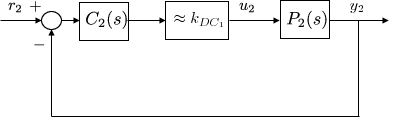

In [12]:
img5

In [13]:
#TODO Add an interactive example with successive loop closure

## E. Input Saturation and Limits of Performance
TODO: Make this an interactive section!!!

All physical systems have saturation limit on their actuators.  For example, in the robot arm problem, the torque that can be applied to the arm is limited by the motor that is used to apply that torque.  Force and torque will always be limited by physical constraints like current limits.  Similarly, for an airplane, the rudder command is limited by how far the rudder can physically move, which is typically on the order of $\pm 40$~degrees.  A natural way to model input constraints is to add a saturation block preceding the physical plant. 

If the system is to be kept just out of saturation, then immediately after the step we have $|u|=u_\text{max} = k_p e_\text{max}$.  Rearranging this expression, we find that the proportional control gain can be determined from the maximum anticipated output error and the saturation limits of the actuator as
\begin{equation}
	k_p = \pm \frac{u_\text{max}}{e_\text{max}},
	\label{eq:loop-sat-kp}
\end{equation}
where $u_{\max}$ is the maximum control effort the system can provide, and $e_{\max}$ is the step error that results from a step input of nominal size, and the sign of $k_p$ is determined by the physics of the system.

Suppose that the desired closed loop characteristic polynomial is given by
$$ \Delta_{cl}^d(s) = s^2 + 2\zeta\omega_n s + \omega_n^2,$$
then by comparing with the actual closed loop characteristic polynomial
$$ \Delta_{cl}(s) = s^2 + (a_1 + b_0 k_d)s + (a_0 + b_0 k_p) $$
we have that 
\begin{align*}
	\omega_n &= \sqrt{a_0 + b_0 k_p} \\
	 &\leq \sqrt{a_0 + b_0 \frac{u_\text{max}}{e_\text{max}}},
\end{align*}

which is an upper limit on the natural frequency of the closed-loop system, ensuring that saturation of the actuator is avoided.  The corresponding rise time constraint is
$$ t_r \geq \frac{2.2}{\omega_n} = \frac{2.2}{\sqrt{a_0 + b_0 \frac{u_\text{max}}{e_\text{max}}}},$$
which is the smallest possible rise time for an error step of $e_{\text{max}}$.  


# Example: Design Study A: Single-link Robot Arm
For the single link robot arm, do the following:

> (a) Suppose that the design requirements are that the rise time is
$t_r \approx 0.8$ seconds, with a damping ratio of $\zeta=0.707$.  Find the desired closed loop characteristic polynomial $\Delta_{cl}^d(s)$, and the associated pole locations. Find the proportional and derivative gains $k_P$ and $k_D$ to achieve these specifications, and modify the Simulink simulation from HW A.8 to verify that the step response satisfies the requirements.

> (b) Suppose that the input torque for the robot arm is limited to $|\tau| \leq\tau_{\max}=1$ Nm.  Modify the Simulink diagram to include a saturation block on the torque $\tau$.  Using the rise time $t_r$ and damping ratio $\zeta$ as tuning parameters, tune the PD control law  so that the input just saturates when a step of size $50$~degrees is placed on $\tilde{\theta}^r$.


In [14]:
# Design Problem A : Arm
sys.path.append('./arm/')
sys.path.append('./arm/hw8/')  # add homework directory
import armParam as P
from armDynamics import armDynamics
from armController import armController
from signalGenerator import signalGenerator
from armAnimation import armAnimation
from armPlotData import armPlotData
# TODO: rename the plotData classes, one for each of the Design Studies, as they really are different. 

kp:  0.45374999999999993
kd:  0.06665499999999998


ImportError: No module named 'plotData'

## A - (a): Find PD gains, Simulate

In [15]:
tr=0.8
zeta=0.707

#From eq 8.5 in text
wn=2.2/tr
print('Desired natural freq: ',str(wn))

# Desired closed loop polynomial is then: 
den=[1.,2.*zeta*wn,wn*wn]
print('Desired Closed Loop Polynomial:',den)

# The closed loop polynomial gives us our \alpha values, from Ch 7:
alpha0 = den[2]
alpha1 = den[1]

# Use the information from the open loop characteristic polynomial, from Ch 7.  
b0 = 66.667
a0 = 0.
a1 = 3.333

kP = (alpha0 - a0)/b0
kD = (alpha1 - a1)/b0

print('Defined kP is then:',kP,'Defined kD is then:',kD,sep='\n')

# Now animate with the selected gains: 
%matplotlib tk  
#Allows the images to come up as pop-up, so that the animations will occur properly
import armParam as P
from armDynamics import armDynamics
from armController import armController
from signalGenerator import signalGenerator
from armAnimation import armAnimation
from armPlotData import armPlotData

# instantiate arm, controller, and reference classes
arm = armDynamics()
ctrl = armController(kP,kD)
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

Desired natural freq:  2.75
Desired Closed Loop Polynomial: [1.0, 3.8884999999999996, 7.5625]
Defined kP is then:
0.11343693281533591
Defined kD is then:
0.008332458337708303


In [16]:
tr=0.8
zeta=0.707

#From eq 8.5 in text
wn=2.2/tr
print('Desired natural freq: ',str(wn))

# Desired closed loop polynomial is then: 
den=[1.,2.*zeta*wn,wn*wn]
print('Desired Closed Loop Polynomial:',den)

# The closed loop polynomial gives us our \alpha values, from Ch 7:
alpha0 = den[2]
alpha1 = den[1]

# Use the information from the open loop characteristic polynomial, from Ch 7.  
b0 = 66.667
a0 = 0.
a1 = 3.333

kP = (alpha0 - a0)/b0
kD = (alpha1 - a1)/b0

print('Defined kP is then:',kP,'Defined kD is then:',kD,sep='\n')

Desired natural freq:  2.75
Desired Closed Loop Polynomial: [1.0, 3.8884999999999996, 7.5625]
Defined kP is then:
0.11343693281533591
Defined kD is then:
0.008332458337708303


In [17]:
# Now animate with the selected gains: 
# instantiate arm, controller, and reference classes
arm = armDynamics()
ctrl = armController(kP,kD)
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
dataPlot = armPlotData()
animation = armAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.u(ref_input, arm.outputs())  # Calculate the control value
        arm.propagateDynamics(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.drawArm(arm.states())
    dataPlot.updatePlots(t, ref_input, arm.states(), u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation
    

## A - (b) Saturation and Quick Response

In [18]:
tmax = 1.
emax = 50.*np.pi/180.
tr = 2.2/(np.sqrt(a0+b0*tmax/emax))
print('Rise Time: ',tr)
wnd = 2.2/tr
print('Desired wn: ',wnd)
zeta = 0.707
den=[1.,2.*zeta*wnd,wnd*wnd]
alpha0 = den[2]
alpha1 = den[1]
kP = (alpha0 - a0)/b0
kD = (alpha1 - a1)/b0

print('Defined kP is then:',kP,'Defined kD is then:',kD,sep='\n')

Rise Time:  0.2517044597771736
Desired wn:  8.740409295677932
Defined kP is then:
1.1459155902616467
Defined kD is then:
0.13538840421930784


In [19]:
#Animate with our new kp & kd: 
# instantiate arm, controller, and reference classes
arm = armDynamics()
ctrl = armController(kP,kD)
#ctrl = armController()
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
dataPlot = armPlotData()
animation = armAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.u(ref_input, arm.outputs())  # Calculate the control value
        arm.propagateDynamics(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.drawArm(arm.states())
    dataPlot.updatePlots(t, ref_input, arm.states(), u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

# Design Study B: Inverted Pendulum Example

> (a) Using the principle of successive loop closure, draw a block diagram that uses PD control for both inner loop control and outer loop control. The input to the outer loop controller is the desired cart position $z^d$ and the output of the controller is the desired pendulum angle $\theta^d$.  The input to the inner loop controller is the desired pendulum angle $\theta^d$ and the output is the force $F$ on the cart.

> (b) Focusing on the inner loop, find the PD gains $k_{P_\theta}$ and $k_{D_\theta}$ so that the rise time of the inner loop is $t_{r_\theta}=0.5$ seconds, and the damping ratio is $\zeta_{\theta}=0.707$.

> (c) Find the DC gain $k_{DC_\theta}$ of the inner loop.

> (d) Replacing the inner loop by its DC-gain and considering the outer loop, show that it is not possible to use the coefficient-matching approach to determine PD control gains. Further, convince yourself that using the DC-gain approximation for the inner loop, it is not possible to stabilize the position of the cart with PD control alone. We will investigate other methods to solve this problem in future assignments.

>(e) Implement the inner-loop control design to control the pendulum angle in Simulink where the commanded pendulum angle is zero. Modify the Simulink diagram to include a saturation block on the force $F$ to limit the size of the input force on the cart to $F_{\max}=5$ N. Give the pendulum angle an initial condition of 10~deg and simulate the response of the system for 10~seconds to verify that the cart is able to balance the pendulum. 

In [20]:
# Design Problem B : Pendulum
sys.path.remove('./arm/')
sys.path.remove('./arm/hw8/')

In [21]:
sys.path.append('./pendulum/')
sys.path.append('./pendulum/hw8/')  # add homework directory
import pendulumParam as P
from pendulumDynamics import pendulumDynamics
from pendulumController import pendulumController
from signalGenerator import signalGenerator
from pendulumAnimation import pendulumAnimation
from pendulumPlotData import pendulumPlotData
# TODO: rename all the plot data classes, as they are different for each design problem. 

DC_gain 3.53099173553719
kp_th:  -17.09
kd_th:  -1.5554000000000001
kp_z:  0.005594774363812232
kd_z:  0.030179415101324325


## B Part (a): Draw block diagrams for two successive loops

From the solution in Chapter 5, we have the open-loop expressions: 
$$ \frac{\tilde{\Theta}(s)}{\tilde{F}(s)} = \frac{\frac{-2}{m_2 \ell}}{ s^2 -\frac{(m_1+m_2)g}{m_2 \ell}} $$
$$ \frac{\tilde{Z}(s)}{\tilde{\Theta}(s)} = -\frac{\frac{\ell}{2} s^2 - g}{s^2} .$$

Now we need to close a PD feedback loop around each of these open loop plants.  Below is a block diagram for the inner feedback loop.

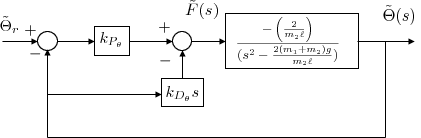

In [22]:
img6

Below is a block diagram for the outer feedback loop

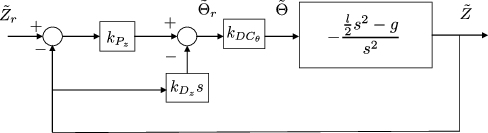

In [23]:
img7

## B Part (b): Find kP and kD for Inner Loop

In [24]:
tr=0.5
zeta=0.707

#From eq 8.5 in text
wn=2.2/tr
print('Desired natural freq: ',str(wn))

# Desired closed loop polynomial is then: 
den=[1.,2.*zeta*wn,wn*wn]
print('Desired Closed Loop Polynomial:',den)

# The closed loop polynomial gives us our \alpha values, from Ch 7:
alpha0 = den[2]
alpha1 = den[1]

# Use the information from the open loop characteristic polynomial 
b0 = -2./(P.m2*P.ell)
a0 = -2*(P.m1 + P.m2)*P.g/(P.m2*P.ell)
a1 = 0.

kP = (alpha0 - a0)/b0
kD = (alpha1 - a1)/b0

print('Defined kP is then:',kP,'Defined kD is then:',kD,sep='\n')

Desired natural freq:  4.4
Desired Closed Loop Polynomial: [1.0, 6.2216000000000005, 19.360000000000003]
Defined kP is then:
-17.09
Defined kD is then:
-1.5554000000000001


## B Part (c): Find the DC Gain of the Inner Feedback Loop

Looking at the expression in equation 7.3, and then applying the DC Gain equation, we have
$$\frac{b_0 k_P}{(a_0 + b_0 k_P)} $$

In [25]:
DC = b0*kP/(a0 + b0*kP)
print('DC Gain: ',DC)

DC Gain:  3.53099173553719


## B Part (d): Consider the Outer Loop

Consider the following figure again: 

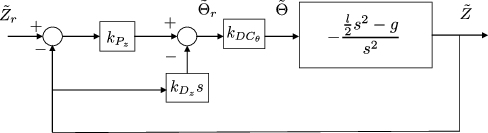

In [26]:
img7

For the comparison approach to set the kP and kD gains, we assume that the 2nd order system doesn't have any zeros, which this plant has two. Those zeros can cause large discrepancies to the desired plant rise time and overshoot, like you can examine above.  

The book pushes forward and uses the proposed method anyway (and ignors the zeros) to derive some PD gains, to be able to implment for the visualization.  



## B Part (e): Visualize the system with some initial conditions. 

In [28]:
# Visualize the system: 

%matplotlib tk   #Allows the images to come up as pop-up, so that the animations will occur properly

# Overwrite the intial conditions: 
P.theta0 = 10.0*np.pi/180
P.t_end = 10.

pendulum = pendulumDynamics()
ctrl = pendulumController(kP,kD) # put in the gains we computed above for the inner loop. 
#reference = signalGenerator(amplitude=0.5, frequency=0.02)

# instantiate the simulation plots and animation
dataPlot = pendulumPlotData()
animation = pendulumAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    #ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        #u = ctrl.u(ref_input, pendulum.outputs())  # Calculate the control value
        u = ctrl.u([0.,0.], pendulum.outputs())  # Calculate the control value
        pendulum.propagateDynamics(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.drawPendulum(pendulum.states())
    #dataPlot.updatePlots(t, ref_input, pendulum.states(), u)
    dataPlot.updatePlots(t, [0.0,0.0], pendulum.states(), u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

# Design Study C: Satellite Example

>(a) **For this problem and future problems**, change the satellite spring constant to $k = 0.1$ N m. For the simple satellite system, using the principle of successive loop closure, draw a block diagram that uses PD control for the inner and the outer loop control. The input to the outer loop controller is the desired angle of the solar panel $\phi_r$ and the output is the desired angle of the satellite $\theta_r$.  The input to the inner loop controller is $\theta_r$ and the output is the torque on the satellite $\tau$.

>(b) Focusing on the inner loop, find the PD gains $k_{P_\theta}$ and $k_{D_\theta}$ so that the rise time of the inner loop is $t_{r_\theta}=1$ second, and the damping ratio is $\zeta_{\theta}=0.9$.

>(c) Find the DC gain $k_{DC_\theta}$ of the inner loop.

>(d) Replacing the inner loop by its DC-gain, find the PD gains $k_{P_\phi}$ and $k_{D_\phi}$ so that the rise time of the outer loop is $t_{r_\phi}= 10 t_{r_\theta}$ with damping ratio $\zeta_{\phi}=0.9$.

>(f) Implement the successive loop closure design for the satellite system in Simulink where the commanded solar panel angle is given by a square wave with magnitude $15$ degrees and frequency $0.015$ Hz.

>(g) Suppose that the size of the input torque on the satellite is limited to $\tau_{\max}=5$ Nm.  Modify the Simulink diagram to include a saturation block on the torque $\tau$.  Using the rise time of the outer loop as a tuning parameter, tune the PD control law to get the fastest possible response without input saturation when a step of size $30$ degrees is placed on $\phi^r$.  

In [29]:
# Design Problem B : Pendulum
sys.path.remove('./pendulum/')
sys.path.remove('./pendulum/hw8/')

In [30]:
sys.path.append('./satellite/')
sys.path.append('./satellite/hw8/')  # add homework directory
import satelliteParam as P
from satelliteDynamics import satelliteDynamics
from satelliteController import satelliteController
from signalGenerator import signalGenerator
from satelliteAnimation import satelliteAnimation
from satellitePlotData import satellitePlotData
# TODO: rename all the plot data classes, as they are different for each design problem. 

P.k = 0.1

k_DC_phi:  0.15599302420380656
kp_th:  29.040000000000006
kd_th:  23.76
kp_phi:  0.18482433045846647
kd_phi:  2.5864729913753983


## C Part (a) Block Diagrams

Block diagram for the inner loop for the satellite 

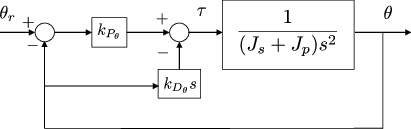

In [31]:
img8

Block diagram for the outer loop of the satellite

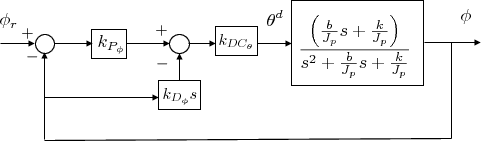

In [32]:
img9

## C Part (b): Find PD gains

In [33]:
tr = 1
zeta = 0.9

#From eq 8.5 in text
wn=2.2/tr
print('Desired natural freq: ',str(wn))

# Desired closed loop polynomial is then: 
den=[1.,2.*zeta*wn,wn*wn]
print('Desired Closed Loop Polynomial:',den)

# The closed loop polynomial gives us our \alpha values, from Ch 7:
alpha0 = den[2]
alpha1 = den[1]

# Use the information from the open loop characteristic polynomial 
b0 = 1./(P.Jp + P.Js)
a0 = 0. 
a1 = 0.

kP_th = (alpha0 - a0)/b0
kD_th = (alpha1 - a1)/b0

print('Defined kP for theta is then:',kP_th,'Defined kD for theta is then:',kD_th,sep='\n')


Desired natural freq:  2.2
Desired Closed Loop Polynomial: [1.0, 3.9600000000000004, 4.840000000000001]
Defined kP for theta is then:
29.040000000000006
Defined kD for theta is then:
23.760000000000005


## C Part (c): Find DC Gain of the inner loop

 The desired characteristic equation for the closed loop is: 
 $$ \Theta(s) = \frac{\frac{k_{P_\theta}}{J_s + J_p}}{s^2 +\left(\frac{k_{D_\theta}}{J_s + J_p}\right)s+\left(\frac{k_{P_\theta}}{J_s + J_p}\right)} \Theta^d(s).$$
 
 Therefore, the DC gain is `1`

## C Part (d): Find PD gains of the outer loop

In [34]:
tr = 10
zeta = 0.9
k_DC_th = 1.

#From eq 8.5 in text
wn=2.2/tr
print('Desired natural freq: ',str(wn))

# Desired closed loop polynomial is then: 
den=[1.,2.*zeta*wn,wn*wn]
print('Desired Closed Loop Polynomial:',den)

# The closed loop polynomial gives us our \alpha values, from Ch 7:
alpha0 = den[2]
alpha1 = den[1]

# Need to use the closed-loop TF characteristic equation to compare to the one above, since we have the zero involved. 
AA = np.matrix([
    [P.k*k_DC_th, -P.Jp*P.b*k_DC_th],
    [P.b*k_DC_th, P.k*k_DC_th-2*zeta*wn*P.b*k_DC_th]])
bb = np.matrix([
    [-P.k+P.Jp*wn**2],
    [-P.b+2*P.Jp*zeta*wn]])
tmp = np.linalg.inv(AA)*bb
kP_ph = tmp.item(0)
kD_ph = tmp.item(1)

print('Defined kP for phi is then:',kP_ph,'Defined kD for phi is then:',kD_ph,sep='\n')

Desired natural freq:  0.22000000000000003
Desired Closed Loop Polynomial: [1.0, 0.3960000000000001, 0.04840000000000001]
Defined kP for phi is then:
1.2511102661596967
Defined kD for phi is then:
3.5342205323193934


## C Part (f - really e): Simulate the system


In [35]:
%matplotlib tk  
# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics()
ctrl = satelliteController()#kP_th,kD_th,kP_ph,kD_ph)
reference = signalGenerator(amplitude=15.0*np.pi/180.0, frequency=0.015)

# set disturbance input (unused here)
disturbance = 0.0

# instantiate the simulation plots and animation
dataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.u(ref_input, satellite.outputs())  # Calculate the control value
        sys_input = [u[0]+disturbance]  # input to plant is control input + disturbance (formatted as a list)
        satellite.propagateDynamics(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.drawSatellite(satellite.states())
    dataPlot.updatePlots(t, ref_input, satellite.states(), u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

## C Part (g - really f): Saturation and Quick Response

In [36]:
tmax = 5.
emax = 30.*np.pi/180.
tr = 5 #2.2/(np.sqrt(a0+b0*tmax/emax))
print('Rise Time: ',tr)
wn = 2.2/tr
print('Desired wn: ',wnd)
zeta = 0.9
den=[1.,2.*zeta*wnd,wnd*wnd]
alpha0 = den[2]
alpha1 = den[1]

# Need to use the closed-loop TF characteristic equation to compare to the one above, since we have the zero involved. 
AA = np.matrix([
    [P.k*k_DC_th, -P.Jp*P.b*k_DC_th],
    [P.b*k_DC_th, P.k*k_DC_th-2*zeta*wn*P.b*k_DC_th]])
bb = np.matrix([
    [-P.k+P.Jp*wn**2],
    [-P.b+2*P.Jp*zeta*wn]])
tmp = np.linalg.inv(AA)*bb
kP_ph = tmp.item(0)
kD_ph = tmp.item(1)

print('Defined kP is then:',kP_ph,'Defined kD is then:',kD_ph,sep='\n')

Rise Time:  5
Desired wn:  8.740409295677932
Defined kP is then:
5.006257611241219
Defined kD is then:
8.140515222482435


In [37]:
# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics()
ctrl = satelliteController(kP_th,kD_th,kP_ph,kD_ph)
reference = signalGenerator(amplitude=30.0*np.pi/180.0, frequency=0.015)

# set disturbance input (unused here)
disturbance = 0.0

# instantiate the simulation plots and animation
dataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.u(ref_input, satellite.outputs())  # Calculate the control value
        sys_input = [u[0]+disturbance]  # input to plant is control input + disturbance (formatted as a list)
        satellite.propagateDynamics(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.drawSatellite(satellite.states())
    dataPlot.updatePlots(t, ref_input, satellite.states(), u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

Note that the DC gain of the outer closed loop $\ne$ 1, so there will be steady-state error in the system.  We will deal with this in a future chapter. 